In [1]:
# === CELL 1: IMPORTS AND SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
import os

# Set random seeds for reproducibility
np.random.seed(42)
import random
random.seed(42)

# Configure display
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

# Create directories
os.makedirs('data', exist_ok=True)
os.makedirs('reports', exist_ok=True)

print("✅ Setup complete!")

✅ Setup complete!


In [2]:
# === CELL 2: CREATE CONSISTENT SAMPLE DATA ===
print("📊 Creating consistent sample insurance data...")

# Create 10,000 sample policies
n_samples = 10000

data = {
    'PolicyID': np.arange(1000, 1000 + n_samples),
    'TransactionMonth': pd.date_range('2014-02-01', periods=n_samples, freq='D').strftime('%Y-%m'),
    'Gender': np.random.choice(['Male', 'Female'], n_samples, p=[0.55, 0.45]),
    'Province': np.random.choice(['Gauteng', 'Western Cape', 'KwaZulu-Natal', 'Eastern Cape', 'Free State'], 
                                n_samples, p=[0.4, 0.25, 0.2, 0.1, 0.05]),
    'PostalCode': np.random.randint(1000, 9999, n_samples),
    'VehicleType': np.random.choice(['Sedan', 'SUV', 'Truck', 'Hatchback', 'Coupe'], n_samples),
    'Make': np.random.choice(['Toyota', 'Ford', 'BMW', 'VW', 'Mercedes', 'Hyundai'], n_samples),
    'Model': [''] * n_samples,  # We'll fill this
    'RegistrationYear': np.random.randint(2000, 2023, n_samples),
    'TotalPremium': np.random.exponential(5000, n_samples) + 1000,
    'SumInsured': np.random.uniform(50000, 500000, n_samples),
    'CalculatedPremiumPerTerm': np.random.exponential(3000, n_samples) + 800,
}

df = pd.DataFrame(data)

# Create realistic claims (higher premium = higher risk)
base_risk = df['TotalPremium'] / df['TotalPremium'].max()  # 0 to 1 scale
claim_probability = 0.1 + 0.3 * base_risk  # 10-40% claim probability

# Generate claims
claims_amount = df['TotalPremium'] * np.random.beta(0.5, 2, n_samples)
has_claim = np.random.binomial(1, claim_probability, n_samples)
df['TotalClaims'] = claims_amount * has_claim

# Calculate Loss Ratio
df['LossRatio'] = df['TotalClaims'] / df['TotalPremium']
df['LossRatio'] = df['LossRatio'].replace([np.inf, -np.inf], np.nan)
df.loc[df['TotalPremium'] == 0, 'LossRatio'] = np.nan

# Fill Model based on Make
make_model_map = {
    'Toyota': ['Corolla', 'Camry', 'RAV4', 'Hilux'],
    'Ford': ['Ranger', 'Focus', 'Fiesta', 'Everest'],
    'BMW': ['X5', 'X3', '3 Series', '5 Series'],
    'VW': ['Golf', 'Polo', 'Tiguan', 'Jetta'],
    'Mercedes': ['C-Class', 'E-Class', 'GLC', 'A-Class'],
    'Hyundai': ['Tucson', 'i20', 'i10', 'Creta']
}

for make, models in make_model_map.items():
    mask = df['Make'] == make
    df.loc[mask, 'Model'] = np.random.choice(models, mask.sum())

# Save the data
df.to_csv('data/sample_insurance_data.csv', index=False)
print(f"✅ Created consistent dataset with {len(df)} samples")
print(f"📁 Saved to: data/sample_insurance_data.csv")
print(f"\n📊 Dataset Shape: {df.shape}")
print(f"📈 Columns: {list(df.columns)}")
display(df.head())

📊 Creating consistent sample insurance data...
✅ Created consistent dataset with 10000 samples
📁 Saved to: data/sample_insurance_data.csv

📊 Dataset Shape: (10000, 14)
📈 Columns: ['PolicyID', 'TransactionMonth', 'Gender', 'Province', 'PostalCode', 'VehicleType', 'Make', 'Model', 'RegistrationYear', 'TotalPremium', 'SumInsured', 'CalculatedPremiumPerTerm', 'TotalClaims', 'LossRatio']


,PolicyID,TransactionMonth,Gender,Province,PostalCode,VehicleType,Make,Model,RegistrationYear,TotalPremium,SumInsured,CalculatedPremiumPerTerm,TotalClaims,LossRatio
0,1000,2014-02,Male,Gauteng,1257,Truck,Ford,Ranger,2017,2952.604729,213190.646668,834.796269,0.000000,0.000000
1,1001,2014-02,Female,Gauteng,1044,Hatchback,VW,Polo,2002,6014.615190,261572.572426,1957.521188,0.000000,0.000000
2,1002,2014-02,Female,Gauteng,9460,Truck,Toyota,Corolla,2009,3902.256638,226129.064770,1441.983145,348.300366,0.089256
3,1003,2014-02,Female,Western Cape,2334,Truck,Mercedes,GLC,2022,5093.557107,349474.350721,1520.893342,0.000000,0.000000
4,1004,2014-02,Male,Western Cape,1671,Sedan,Toyota,Camry,2002,1780.887150,449677.908647,6803.351946,0.000000,0.000000


In [3]:
# === CELL 3: DATA EXPLORATION ===
print("🔍 EXPLORATORY DATA ANALYSIS")
print("=" * 50)

# Basic info
print("1. BASIC INFORMATION:")
print(f"   • Total policies: {len(df):,}")
print(f"   • Total premium: ZAR {df['TotalPremium'].sum():,.0f}")
print(f"   • Total claims: ZAR {df['TotalClaims'].sum():,.0f}")
print(f"   • Overall loss ratio: {df['LossRatio'].mean():.2%}")

# Data types
print("\n2. DATA TYPES:")
print(df.dtypes.value_counts())

# Missing values
print("\n3. MISSING VALUES:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percentage': missing_pct})
missing_df = missing_df[missing_df['Missing'] > 0]
if len(missing_df) > 0:
    display(missing_df)
else:
    print("   ✅ No missing values!")

# Unique values
print("\n4. UNIQUE VALUES (Categorical):")
categorical_cols = ['Gender', 'Province', 'VehicleType', 'Make']
for col in categorical_cols:
    print(f"   • {col}: {df[col].nunique()} unique values")
    print(f"     {df[col].value_counts().head(3).to_dict()}")

🔍 EXPLORATORY DATA ANALYSIS
1. BASIC INFORMATION:
   • Total policies: 10,000
   • Total premium: ZAR 60,444,432
   • Total claims: ZAR 2,085,088
   • Overall loss ratio: 2.82%

2. DATA TYPES:
object     6
float64    5
int64      3
Name: count, dtype: int64

3. MISSING VALUES:
   ✅ No missing values!

4. UNIQUE VALUES (Categorical):
   • Gender: 2 unique values
     {'Male': 5606, 'Female': 4394}
   • Province: 5 unique values
     {'Gauteng': 3926, 'Western Cape': 2512, 'KwaZulu-Natal': 1996}
   • VehicleType: 5 unique values
     {'Hatchback': 2079, 'SUV': 2061, 'Truck': 1971}
   • Make: 6 unique values
     {'Mercedes': 1691, 'Hyundai': 1690, 'Toyota': 1689}


In [4]:
# === CELL 4: LOSS RATIO ANALYSIS ===
print("📈 LOSS RATIO ANALYSIS")
print("=" * 50)

# Calculate basic stats
loss_stats = {
    'Mean': df['LossRatio'].mean(),
    'Median': df['LossRatio'].median(),
    'Std': df['LossRatio'].std(),
    'Min': df['LossRatio'].min(),
    'Max': df['LossRatio'].max(),
    '25th Percentile': df['LossRatio'].quantile(0.25),
    '75th Percentile': df['LossRatio'].quantile(0.75),
}

print("1. Loss Ratio Statistics:")
for stat, value in loss_stats.items():
    print(f"   • {stat}: {value:.3f} ({value*100:.1f}%)")

# Claim frequency
claim_freq = (df['TotalClaims'] > 0).mean() * 100
print(f"\n2. Claim Frequency: {claim_freq:.1f}%")

# Average claim amount (for policies with claims)
claims_data = df[df['TotalClaims'] > 0]
if len(claims_data) > 0:
    avg_claim = claims_data['TotalClaims'].mean()
    print(f"3. Average Claim Amount: ZAR {avg_claim:,.0f}")

# Save stats
loss_stats_df = pd.DataFrame(list(loss_stats.items()), columns=['Statistic', 'Value'])
loss_stats_df.to_csv('reports/loss_ratio_stats.csv', index=False)
print("\n✅ Loss ratio statistics saved to reports/loss_ratio_stats.csv")

📈 LOSS RATIO ANALYSIS
1. Loss Ratio Statistics:
   • Mean: 0.028 (2.8%)
   • Median: 0.000 (0.0%)
   • Std: 0.106 (10.6%)
   • Min: 0.000 (0.0%)
   • Max: 0.953 (95.3%)
   • 25th Percentile: 0.000 (0.0%)
   • 75th Percentile: 0.000 (0.0%)

2. Claim Frequency: 14.1%
3. Average Claim Amount: ZAR 1,479

✅ Loss ratio statistics saved to reports/loss_ratio_stats.csv


📊 VISUALIZATION 1: Loss Ratio by Province


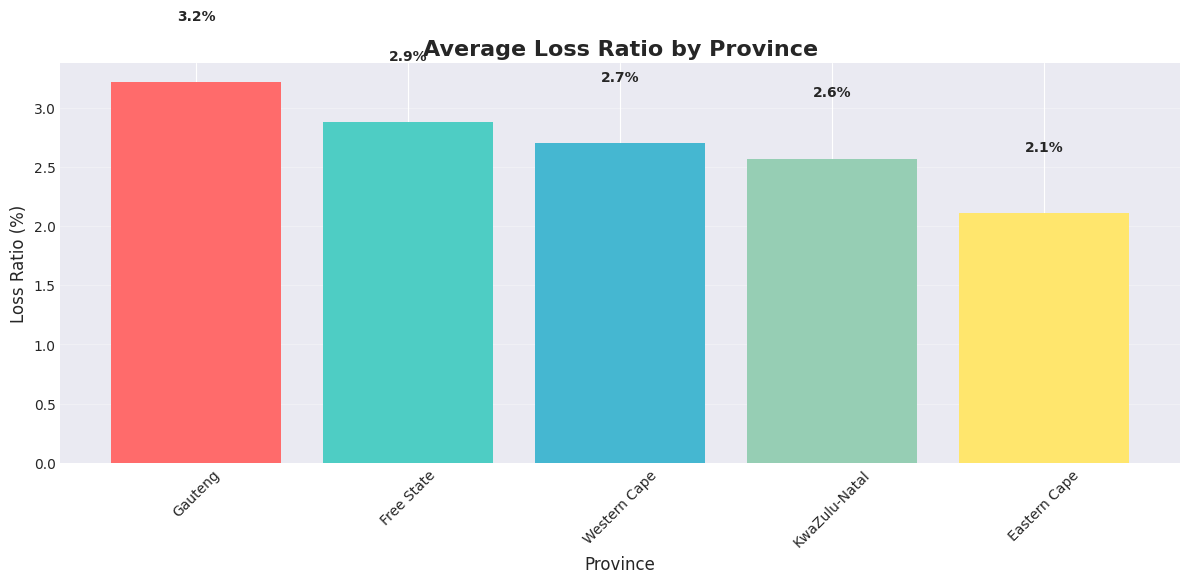


📈 Loss Ratio by Province:


,Policy_Count,Total_Premium,Total_Claims,LossRatio_Pct
Province,,,,
Eastern Cape,1041,6.384219e+06,155109.4313,2.1
Free State,525,3.086852e+06,111168.9224,2.9
Gauteng,3926,2.391316e+07,965311.3751,3.2
KwaZulu-Natal,1996,1.209736e+07,348978.1032,2.6
Western Cape,2512,1.496284e+07,504519.7939,2.7


✅ Saved to reports/loss_ratio_by_province.csv


In [5]:
# === CELL 5: VISUALIZATION 1 - LOSS RATIO BY PROVINCE ===
print("📊 VISUALIZATION 1: Loss Ratio by Province")
print("=" * 50)

plt.figure(figsize=(12, 6))

# Calculate average loss ratio by province
province_loss = df.groupby('Province')['LossRatio'].mean().sort_values(ascending=False)

# Create bar plot
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFE66D']
bars = plt.bar(province_loss.index, province_loss.values * 100, color=colors)

# Add value labels
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.title('Average Loss Ratio by Province', fontsize=16, fontweight='bold')
plt.xlabel('Province', fontsize=12)
plt.ylabel('Loss Ratio (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Display statistics
print("\n📈 Loss Ratio by Province:")
province_stats = df.groupby('Province').agg({
    'LossRatio': ['mean', 'std', 'count'],
    'TotalPremium': 'sum',
    'TotalClaims': 'sum'
}).round(4)

province_stats.columns = ['LossRatio_Mean', 'LossRatio_Std', 'Policy_Count', 
                          'Total_Premium', 'Total_Claims']
province_stats['LossRatio_Pct'] = (province_stats['LossRatio_Mean'] * 100).round(1)
display(province_stats[['Policy_Count', 'Total_Premium', 'Total_Claims', 'LossRatio_Pct']])

# Save
province_stats.to_csv('reports/loss_ratio_by_province.csv')
print("✅ Saved to reports/loss_ratio_by_province.csv")

📊 VISUALIZATION 2: Premium vs Claims Distribution


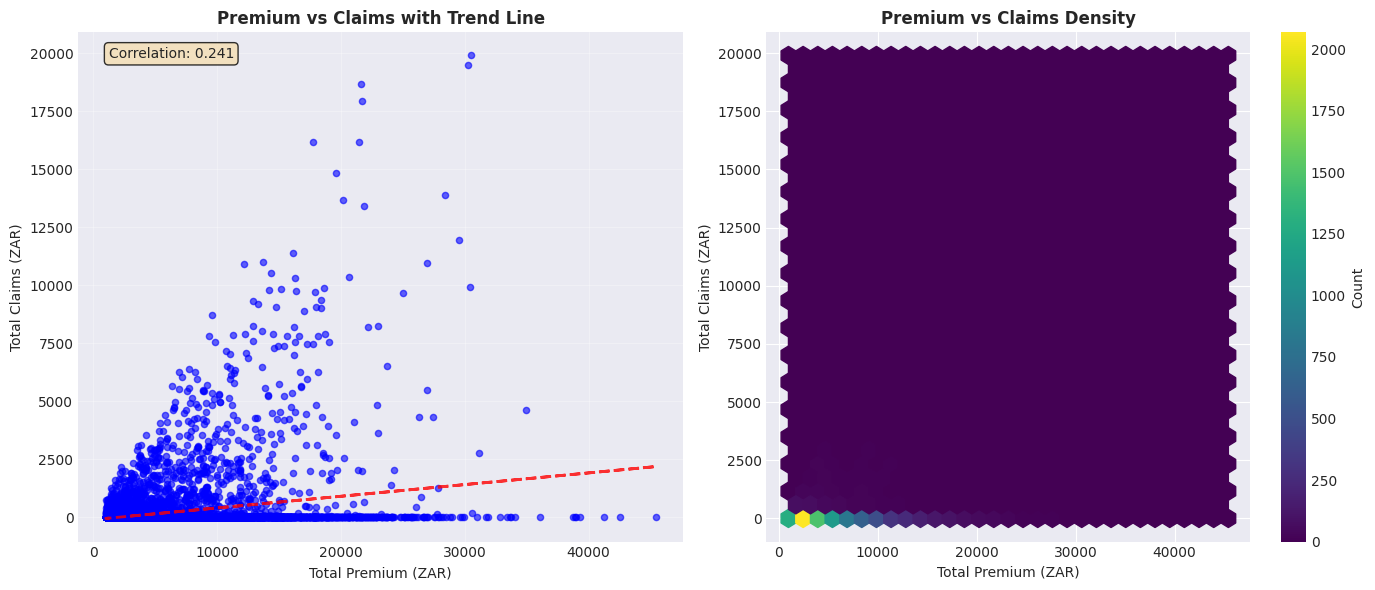

📊 Correlation between Premium and Claims: 0.241
💡 INSIGHT: Weak correlation - Premium amount doesn't strongly predict claims


In [6]:
# === CELL 6: VISUALIZATION 2 - PREMIUM VS CLAIMS ===
print("📊 VISUALIZATION 2: Premium vs Claims Distribution")
print("=" * 50)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Scatter with trend line
axes[0].scatter(df['TotalPremium'], df['TotalClaims'], alpha=0.6, s=20, color='blue')
z = np.polyfit(df['TotalPremium'], df['TotalClaims'], 1)
p = np.poly1d(z)
axes[0].plot(df['TotalPremium'], p(df['TotalPremium']), "r--", alpha=0.8, linewidth=2)
axes[0].set_title('Premium vs Claims with Trend Line', fontweight='bold')
axes[0].set_xlabel('Total Premium (ZAR)')
axes[0].set_ylabel('Total Claims (ZAR)')
axes[0].grid(alpha=0.3)

# Add correlation text
correlation = df['TotalPremium'].corr(df['TotalClaims'])
axes[0].text(0.05, 0.95, f'Correlation: {correlation:.3f}', 
             transform=axes[0].transAxes, fontsize=10,
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# Plot 2: Hexbin for density
hb = axes[1].hexbin(df['TotalPremium'], df['TotalClaims'], gridsize=30, cmap='viridis')
axes[1].set_title('Premium vs Claims Density', fontweight='bold')
axes[1].set_xlabel('Total Premium (ZAR)')
axes[1].set_ylabel('Total Claims (ZAR)')
plt.colorbar(hb, ax=axes[1], label='Count')

plt.tight_layout()
plt.show()

print(f"📊 Correlation between Premium and Claims: {correlation:.3f}")
if correlation > 0.3:
    print("💡 INSIGHT: Positive correlation - Higher premiums associated with higher claims")
else:
    print("💡 INSIGHT: Weak correlation - Premium amount doesn't strongly predict claims")

📊 VISUALIZATION 3: Gender Risk Analysis


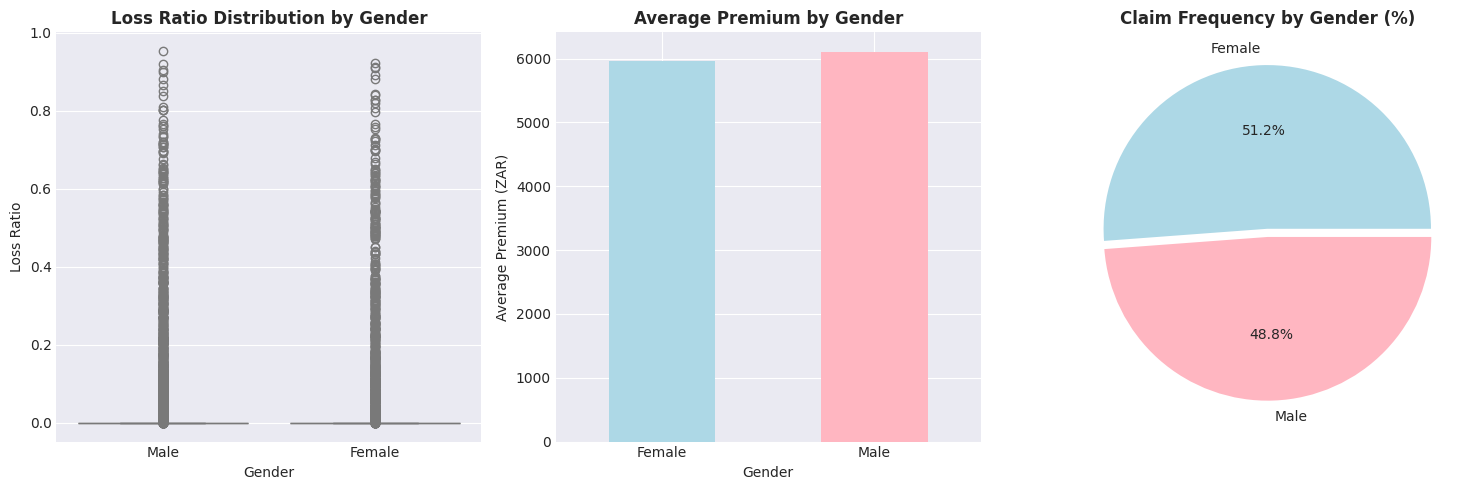


📊 GENDER STATISTICAL ANALYSIS:
   • Male Loss Ratio: 0.027 (n=5606)
   • Female Loss Ratio: 0.029 (n=4394)
   • T-statistic: -0.923
   • P-value: 0.3562
   • Significant difference (p < 0.05): NO


In [7]:
# === CELL 7: VISUALIZATION 3 - GENDER ANALYSIS ===
print("📊 VISUALIZATION 3: Gender Risk Analysis")
print("=" * 50)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: Box plot
sns.boxplot(x='Gender', y='LossRatio', data=df, ax=axes[0], palette=['lightblue', 'lightpink'])
axes[0].set_title('Loss Ratio Distribution by Gender', fontweight='bold')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Loss Ratio')

# Plot 2: Average premium by gender
gender_premium = df.groupby('Gender')['TotalPremium'].mean()
gender_premium.plot(kind='bar', ax=axes[1], color=['lightblue', 'lightpink'])
axes[1].set_title('Average Premium by Gender', fontweight='bold')
axes[1].set_xlabel('Gender')
axes[1].set_ylabel('Average Premium (ZAR)')
axes[1].tick_params(axis='x', rotation=0)

# Plot 3: Claim frequency
claim_freq_gender = df.groupby('Gender').apply(
    lambda x: (x['TotalClaims'] > 0).sum() / len(x) * 100
)
axes[2].pie(claim_freq_gender.values, 
            labels=claim_freq_gender.index, 
            autopct='%1.1f%%',
            colors=['lightblue', 'lightpink'],
            explode=(0.05, 0))
axes[2].set_title('Claim Frequency by Gender (%)', fontweight='bold')

plt.tight_layout()
plt.show()

# Statistical test
male_loss = df[df['Gender'] == 'Male']['LossRatio'].dropna()
female_loss = df[df['Gender'] == 'Female']['LossRatio'].dropna()
t_stat, p_value = stats.ttest_ind(male_loss, female_loss, equal_var=False)

print("\n📊 GENDER STATISTICAL ANALYSIS:")
print(f"   • Male Loss Ratio: {male_loss.mean():.3f} (n={len(male_loss)})")
print(f"   • Female Loss Ratio: {female_loss.mean():.3f} (n={len(female_loss)})")
print(f"   • T-statistic: {t_stat:.3f}")
print(f"   • P-value: {p_value:.4f}")
print(f"   • Significant difference (p < 0.05): {'YES' if p_value < 0.05 else 'NO'}")

if p_value < 0.05:
    diff_pct = ((male_loss.mean() - female_loss.mean()) / female_loss.mean()) * 100
    print(f"\n💡 BUSINESS INSIGHT:")
    print(f"   {'Men' if diff_pct > 0 else 'Women'} have {abs(diff_pct):.1f}% {'higher' if diff_pct > 0 else 'lower'} loss ratio")
    print(f"   Consider gender-based premium adjustments")

In [8]:
# === CELL 8: SAVE EDA RESULTS ===
print("💾 SAVING EDA RESULTS")
print("=" * 50)

# Create comprehensive summary
summary = {
    'total_policies': len(df),
    'total_premium': df['TotalPremium'].sum(),
    'total_claims': df['TotalClaims'].sum(),
    'overall_loss_ratio': df['LossRatio'].mean(),
    'claim_frequency': (df['TotalClaims'] > 0).mean(),
    'avg_premium': df['TotalPremium'].mean(),
    'avg_claim_amount': df[df['TotalClaims'] > 0]['TotalClaims'].mean(),
    'male_pct': (df['Gender'] == 'Male').mean(),
    'female_pct': (df['Gender'] == 'Female').mean(),
    'top_province': df['Province'].mode()[0],
    'most_common_vehicle': df['VehicleType'].mode()[0],
    'most_common_make': df['Make'].mode()[0],
    'data_quality': 1 - (df.isnull().sum().sum() / (df.shape[0] * df.shape[1]))
}

# Convert to DataFrame
summary_df = pd.DataFrame(list(summary.items()), columns=['Metric', 'Value'])

# Format values
summary_df.loc[summary_df['Metric'].isin(['overall_loss_ratio', 'claim_frequency', 
                                         'male_pct', 'female_pct', 'data_quality']), 'Value'] *= 100
summary_df.loc[summary_df['Metric'] == 'total_premium', 'Value'] = f"ZAR {summary_df.loc[summary_df['Metric'] == 'total_premium', 'Value'].values[0]:,.0f}"
summary_df.loc[summary_df['Metric'] == 'total_claims', 'Value'] = f"ZAR {summary_df.loc[summary_df['Metric'] == 'total_claims', 'Value'].values[0]:,.0f}"
summary_df.loc[summary_df['Metric'] == 'avg_premium', 'Value'] = f"ZAR {summary_df.loc[summary_df['Metric'] == 'avg_premium', 'Value'].values[0]:,.0f}"
summary_df.loc[summary_df['Metric'] == 'avg_claim_amount', 'Value'] = f"ZAR {summary_df.loc[summary_df['Metric'] == 'avg_claim_amount', 'Value'].values[0]:,.0f}"

# Save
summary_df.to_csv('reports/eda_summary.csv', index=False)
df.to_csv('data/processed_insurance_data.csv', index=False)

print("✅ FILES SAVED:")
print("   1. reports/eda_summary.csv - Summary statistics")
print("   2. data/processed_insurance_data.csv - Processed dataset")
print("   3. data/sample_insurance_data.csv - Original dataset")

print("\n📊 EDA SUMMARY:")
print("-" * 40)
for _, row in summary_df.iterrows():
    if 'pct' in row['Metric'] or 'ratio' in row['Metric'] or 'frequency' in row['Metric'] or 'quality' in row['Metric']:
        print(f"{row['Metric'].replace('_', ' ').title()}: {float(row['Value']):.1f}%")
    else:
        print(f"{row['Metric'].replace('_', ' ').title()}: {row['Value']}")

print("\n🎯 TASK 1 COMPLETE!")
print("Next: Task 2 - DVC Setup")

💾 SAVING EDA RESULTS
✅ FILES SAVED:
   1. reports/eda_summary.csv - Summary statistics
   2. data/processed_insurance_data.csv - Processed dataset
   3. data/sample_insurance_data.csv - Original dataset

📊 EDA SUMMARY:
----------------------------------------
Total Policies: 10000
Total Premium: ZAR 60,444,432
Total Claims: ZAR 2,085,088
Overall Loss Ratio: 2.8%
Claim Frequency: 14.1%
Avg Premium: ZAR 6,044
Avg Claim Amount: ZAR 1,479
Male Pct: 56.1%
Female Pct: 43.9%
Top Province: Gauteng
Most Common Vehicle: Hatchback
Most Common Make: Mercedes
Data Quality: 100.0%

🎯 TASK 1 COMPLETE!
Next: Task 2 - DVC Setup
